# COMP5623 Coursework on Image Caption Generation

Starter code.



## Text preparation 

We need to build a vocabulary.

In [0]:
# Mounted Drive if using Colab; otherwise, your local path
root = "/content/gdrive/My Drive/AI/" # <--- replace this with your root data directory
caption_dir = root + "captions/"                       # <--- replace these too
image_dir = root + "images/"                           # <---

token_file = "Flickr8k.token.txt"

A helper function to read in our ground truth text file.

In [0]:
def read_lines(filepath):
    """ Open the ground truth captions into memory, line by line. """
    file = open(filepath, 'r')
    lines = []

    while True: 
        # Get next line from file until there's no more
        line = file.readline() 
        if not line: 
            break
        lines.append(line.strip())
    file.close() 
    return lines

You can read all the ground truth captions (5 per image), into memory as follows:

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
lines = read_lines(caption_dir + token_file)

In [5]:
lines[:5]

['1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .']

In [0]:
class Vocabulary(object):
    """Simple vocabulary wrapper which maps every unique word to an integer ID. """
    def __init__(self):
        # Intially, set both the IDs and words to empty dictionaries.
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        # If the word does not already exist in the dictionary, add it
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            # Increment the ID for the next word
            self.idx += 1

    def __call__(self, word):
        # If we try to access a word in the dictionary which does not exist, return the <unk> id
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

Extract all the words from ```lines```, and create a list of them in a variable ```words```, for example:

```words = ["a", "an", "the", "cat"... ]```

No need to worry about duplicates.


In [0]:
import string

# https://machinelearningmastery.com/clean-text-machine-learning-python/

def get_id(line):
  index = line.index('.jpg', 16, 25)
  return line[:index]

def get_caption(line):
  index = line.index('\t', 18, 33) + 1
  return line[index:]

def get_words(line):
  words = line.lower().split(' ')
  table = str.maketrans('', '', string.punctuation)
  stripped = [w.translate(table).strip() for w in words]
  return list(filter(None, stripped))

In [0]:
words = []

for line in lines:
  for word in get_words(get_caption(line)):
    words.append(word)

Build the vocabulary.

In [0]:
# Create a vocab instance
vocab = Vocabulary()

# Add the token words first
vocab.add_word('<pad>')
vocab.add_word('<start>')
vocab.add_word('<end>')
vocab.add_word('<unk>')

Add the rest of the words from the parsed captions:

``` vocab.add_word('new_word')```

Don't add words that appear three times or less.

In [0]:
from collections import Counter

for key,value in Counter(words).items(): 
  if value > 3:
    vocab.add_word(key)

## Dataset and loaders for training

Keeping the same order, concatenate all the cleaned words from each caption into a string again, and add them all to a list of strings ```cleaned_captions```. Store all the image ids in a list ```image_ids```.

In [0]:
image_ids = []
cleaned_captions = []

for line in lines:
  image_ids.append(get_id(line))
  cleaned_captions.append(' '.join(get_words(get_caption(line))))

The dataframe for the image paths and captions.

In [0]:
import pandas as pd

data = {
    'image_id': image_ids,
    'path': [image_dir + image_id + ".jpg" for image_id in image_ids],
    'caption': cleaned_captions
}

data_df = pd.DataFrame(data, columns=['image_id', 'path', 'caption'])

In [13]:
data_df.head(n=5)

image_id  ...                                            caption
0  1000268201_693b08cb0e  ...  a child in a pink dress is climbing up a set o...
1  1000268201_693b08cb0e  ...                a girl going into a wooden building
2  1000268201_693b08cb0e  ...     a little girl climbing into a wooden playhouse
3  1000268201_693b08cb0e  ...  a little girl climbing the stairs to her playh...
4  1000268201_693b08cb0e  ...  a little girl in a pink dress going into a woo...

[5 rows x 3 columns]

This is the Flickr8k class for the dataset.

In [0]:
from PIL import Image
import cv2
from nltk import tokenize
from torch.utils.data import Dataset

class Flickr8k(Dataset):
    """ Flickr8k custom dataset compatible with torch.utils.data.DataLoader. """
    
    def __init__(self, df, vocab, transform=None):
        """ Set the path for images, captions and vocabulary wrapper.
        
        Args:
            df: df containing image paths and captions.
            vocab: vocabulary wrapper.
            transform: image transformer.
        """
        self.df = df
        self.vocab = vocab
        self.transform = transform

    def __getitem__(self, index):
        """ Returns one data pair (image and caption). """

        vocab = self.vocab

        caption = self.df['caption'][index]
        img_id = self.df['image_id'][index]
        path = self.df['path'][index]

        image = Image.open(open(path, 'rb'))

        if self.transform is not None:
            image = self.transform(image)

        # Convert caption (string) to word ids.
        tokens = caption.split()
        caption = []
        # Build the Tensor version of the caption, with token words
        caption.append(vocab('<start>'))
        caption.extend([vocab(token) for token in tokens])
        caption.append(vocab('<end>'))
        target = torch.Tensor(caption)
        return image, target, img_id

    def __len__(self):
        return len(self.df)

We need to overwrite the default PyTorch ```collate_fn()``` because our ground truth captions are sequential data of varying lengths. The default ```collate_fn()``` does not support merging the captions with padding.

You can read more about it here: https://pytorch.org/docs/stable/data.html#dataloader-collate-fn. 

In [0]:
def caption_collate_fn(data):
    """ Creates mini-batch tensors from the list of tuples (image, caption).
    Args:
        data: list of tuple (image, caption). 
            - image: torch tensor of shape (3, 256, 256).
            - caption: torch tensor of shape (?); variable length.
    Returns:
        images: torch tensor of shape (batch_size, 3, 256, 256).
        targets: torch tensor of shape (batch_size, padded_length).
        lengths: list; valid length for each padded caption.
    """
    # Sort a data list by caption length from longest to shortest.
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions, img_ids = zip(*data)

    # Merge images (from tuple of 3D tensor to 4D tensor).
    images = torch.stack(images, 0)

    # Merge captions (from tuple of 1D tensor to 2D tensor).
    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]        

    return images, targets, lengths, img_ids

Now we define the data transform.

In [0]:
from torchvision import transforms

# Crop size matches the input dimensions expected by the pre-trained ResNet
data_transform = transforms.Compose([ 
    transforms.Resize(224),
    transforms.CenterCrop(224),  # Why do we choose 224 x 224?
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),   # Using ImageNet norms
                         (0.229, 0.224, 0.225))])

Initialising the datasets. The only twist is that every image has 5 ground truth captions, so each image appears five times in the dataframe. We don't want an image to appear in more than one set.

In [0]:
unit_size = 5

train_split = 0.85 # Defines the ratio of train/test data.
valid_split = 0.10

# We didn't shuffle the dataframe yet so this works
train_size = unit_size * round(len(data_df)*train_split / unit_size)
valid_size = unit_size * round(len(data_df)*valid_split / unit_size)

dataset_train = Flickr8k(
    df=data_df[:train_size].reset_index(drop=True),
    vocab=vocab,
    transform=data_transform,
)

dataset_valid = Flickr8k(
    df=data_df[train_size:(train_size + valid_size)].reset_index(drop=True),
    vocab=vocab,
    transform=data_transform,
)

dataset_test = Flickr8k(
    df=data_df[(train_size + valid_size):].reset_index(drop=True),
    vocab=vocab,
    transform=data_transform,
)

Write the dataloaders ```train_loader``` and ```test_loader``` - explicitly replacing the collate_fn:

```train_loader = torch.utils.data.DataLoader(
  ...,
  collate_fn=caption_collate_fn
)```

Set train batch size to 128 and be sure to set ```shuffle=True```

In [0]:
import torch

train_loader = torch.utils.data.DataLoader(
    dataset_train,
    batch_size = 128,
    collate_fn = caption_collate_fn,
    shuffle = True,
    num_workers = 2,
    pin_memory = True
)

valid_loader = torch.utils.data.DataLoader(
    dataset_valid,
    batch_size = 128,
    collate_fn = caption_collate_fn,
    shuffle = False,
    num_workers = 2,
    pin_memory = True
)

test_loader = torch.utils.data.DataLoader(
    dataset_test,
    batch_size = 128, # Forward pass only so batch size can be larger
    collate_fn = caption_collate_fn,
    shuffle = False,
    num_workers = 2,
    pin_memory = True
)

## Encoder and decoder functions

In [0]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence

class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True) # Pre-trained on ImageNet by default
        layers = list(resnet.children())[:-1]      # Keep all layers except the last one
        # Unpack the layers and create a new Sequential
        self.resnet = nn.Sequential(*layers)
        
        # We want a specific output size, which is the size of our embedding, so
        # we feed our extracted features from the last fc layer (dimensions 1 x 1000)
        # into a Linear layer to resize
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        
        # Batch normalisation helps to speed up training
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, images):
        """Extract feature vectors from input images."""
        
        # Complete graph here. Remember to put the ResNet layer in a with torch.no_grad() block
        
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        
        # What is an embedding layer?
        self.embed = nn.Embedding(vocab_size, embed_size)

        # Define this layer (one at a time)
        self.rnn = nn.RNN(embed_size, hidden_size, num_layers, batch_first = True)
        
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seq_length = max_seq_length
        
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        # What is "packing" a padded sequence?
        packed = pack_padded_sequence(embeddings, lengths, batch_first = True) 
        hiddens, _ = self.rnn(packed) # Replace with self.rnn when using RNN
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seq_length):
            hiddens, states = self.rnn(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids


class DecoderLSTM(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        """Set the hyper-parameters and build the layers."""
        super(DecoderLSTM, self).__init__()
        
        # What is an embedding layer?
        self.embed = nn.Embedding(vocab_size, embed_size)

        # Define this layer (one at a time)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first = True)
        
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seq_length = max_seq_length
        
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        # What is "packing" a padded sequence?
        packed = pack_padded_sequence(embeddings, lengths, batch_first = True) 
        hiddens, _ = self.lstm(packed) # Replace with self.rnn when using RNN
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seq_length):
            hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

In [20]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Set training parameters.

In [0]:
embed_size = 256
hidden_size = 512
num_layers = 1
learning_rate = 0.001
num_epochs = 5
log_step = 25
save_step = 1

Initialize the models and set the learning parameters.

In [0]:
import numpy as np

def build_models(encoder_func, decoder_func):
  encoder = encoder_func(embed_size).to(device)
  decoder = decoder_func(embed_size, hidden_size, len(vocab), num_layers).to(device)
  return encoder, decoder

def loss_optimizer(encoder, decoder):
  # Loss and optimizer
  criterion = nn.CrossEntropyLoss()

  # Optimisation will be on the parameters of BOTH the enocder and decoder,
  # but excluding the ResNet parameters, only the new added layers.
  params = list(
      decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters()
  )

  optimizer = torch.optim.Adam(params, lr=learning_rate)
  return criterion, optimizer

## Training functions

The loop to train the model. Feel free to put this in a function if you prefer.

In [0]:
import matplotlib.pyplot as plt
import copy 

def train_model(encoder, decoder, show = False, save = None):


  # Train the models
  total_step = len(train_loader)
  train_losses, validation_losses, scores = [], [], []


  # Show sample images
  if show:
      test_images, test_captions, test_ids =  torch.tensor([], dtype=torch.float32),  [], []
      # Get data
      for i, (images_d, captions_d, _, ids_d) in enumerate(test_loader):
          test_images = torch.cat((test_images, images_d.cpu()))
          test_captions.extend(captions_d.tolist())
          test_ids.extend(ids_d)
      # Get indexes
      unique_ids = set(test_ids)
      ids_image = []
      for idx in unique_ids:
          indices = [i for i, x in enumerate(test_ids) if x == idx]
          ids_image.append(indices)
      # Compute and show BLEU
      print('Before Training')
      for i in range(show):
          references = [test_captions[i] for i in ids_image[i]]
          score = get_BLEU_image(encoder, decoder, test_images[ids_image[i][0]:ids_image[i][0]+1], references, show=True)


  # Training
  for epoch in range(num_epochs):

      running_loss = 0.0
      encoder.train()
      decoder.train()

      for i, (images, captions, lengths, _) in enumerate(train_loader):

          # Set mini-batch dataset
          images = images.to(device)
          captions = captions.to(device)

          # Packed as well as we'll compare to the decoder outputs
          targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

          # Forward, backward and optimize
          features = encoder(images)
          outputs = decoder(features, captions, lengths)

          loss = criterion(outputs, targets)

          # Zero gradients for both networks
          decoder.zero_grad()
          encoder.zero_grad()

          loss.backward()
          optimizer.step()
          
          running_loss += loss.item()
          # Print log info
          if i % log_step == 0:
              print('Epoch [{}/{}], Step [{}/{}]'
                    .format(epoch, num_epochs, i, total_step)) 

      # Summary data
      running_loss = running_loss / len(train_loader)
      train_losses.append(running_loss)
      validation_loss = get_set_loss(valid_loader, encoder, decoder, criterion)
      validation_losses.append(validation_loss) 
      score = get_average_BLEU(test_loader, encoder, decoder)
      scores.append(score)  

      if min(validation_losses) == validation_loss:
          # best_encoder = copy.deepcopy(encoder)
          # best_decoder = copy.deepcopy(decoder)
          best_encoder = encoder
          best_decoder = decoder

      print(f"-------------------------------- \n"
            f"  Epoch {epoch+1}/{num_epochs} \n"
            f"  Train loss: {running_loss:.3f} \n"
            f"  Validation loss: {validation_loss:.3f} \n"
            f"  Average BLEU: {score:.3f}% \n"
            f"--------------------------------")

      # Show sample images
      if show:
          for i in range(show):
              references = [test_captions[i] for i in ids_image[i]]
              score = get_BLEU_image(encoder, decoder, test_images[ids_image[i][0]:ids_image[i][0]+1], references, show=True)
      
      # If you want to save the model checkpoints - recommended once you have everything working
      # Make sure to save RNN and LSTM versions separately
      if save is not None and ((i+1) % save_step == 0):
          path = f'{root}decoder-{save}-{epoch+1}.ckpt'
          torch.save(decoder.state_dict(), F'{path}')
          path = f'{root}encoder-{save}-{epoch+1}.ckpt'
          torch.save(encoder.state_dict(), F'{path}')

  print("Train losses")
  print(train_losses)
  print("Validation losses")
  print(validation_losses)
  plt.figure()
  plt.plot(train_losses, label='Training loss')
  plt.plot(validation_losses, label='Validation loss')
  plt.legend(frameon=False)
  plt.show()

  print("BLEU scores")
  print(scores)

  return best_encoder, best_decoder

In [24]:
# Make sure that we have the last version of NLTK for the BLEU Score
!pip install --upgrade nltk

Requirement already up-to-date: nltk in /usr/local/lib/python3.6/dist-packages (3.5)


In [0]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import matplotlib.pyplot as plt

def get_BLEU_image(encoder, decoder, image, references, show = False):
  # Set evaluation mode
  encoder.eval()
  decoder.eval()
  
  # Set image
  image = image.to(device)
  
  # Generate an caption from the image
  feature = encoder(image)
  outputs = decoder.sample(feature)
  outputs = outputs[0].cpu().numpy()

  # Convert to words without converting 'start', 'end' and 'padding'
  candidate = list( 
      map(lambda idx: vocab.idx2word[idx], [idx for idx in outputs if idx != 1 and idx != 2 and idx != 0])
  )
  candidate = ' '.join(candidate)

  references = [[vocab.idx2word[idx] for idx in ref if idx is not 1 and idx is not 2 and idx is not 0] for ref in references]
  references = [str([' '.join(ref)])[2:-2] for ref in references]

  # Get BLEU score (https://github.com/alvations/nltk/blob/develop/nltk/translate/bleu_score.py#L570)
  score = sentence_bleu(references, candidate, smoothing_function=SmoothingFunction().method4)

  if show is True:
    fig = plt.figure(figsize=(10,4))

    ax1 = plt.subplot(1,2,1)
    ax1.axis('off')
    image = image[0].permute(1, 2, 0).cpu().numpy()
    f_min, f_max = image.min(), image.max()
    image = (image - f_min) / (f_max - f_min)
    ax1.imshow(image)

    ax2 = plt.subplot(1,2,2)
    ax2.axis('off')
    ax2.text(0,0.85,"Ref:" ,fontsize=20)
    for i in range(len(references)):
      ax2.text(0.25, 0.85 - 0.09*i, references[i], fontsize = 15)
    ax2.text(0,0.3,"Pred:",fontsize = 20)
    ax2.text(0.25,0.3, candidate, fontsize = 15)
    ax2.text(0,0.1,"BLEU:".format(score), fontsize = 20)
    ax2.text(0.25,0.1,"{}".format(score), fontsize = 15)

    fig.show()
    print(references)
    print(candidate)
    print(score)

  return score, candidate

def get_average_BLEU(data_loader, encoder, decoder):
  
  # Set evaluation mode
  encoder.eval()
  decoder.eval()

  # Initialize lists
  images, captions, ids =  torch.tensor([], dtype=torch.float32),  [], []
  scores, candidates = [], []

  with torch.no_grad():
    total_step = len(data_loader)
    for i, (images_d, captions_d, _, ids_d) in enumerate(data_loader):
      images = torch.cat((images, images_d.cpu()))
      captions.extend(captions_d.tolist())
      ids.extend(ids_d)

  # Get indexes
  unique_ids = set(ids)
  ids_image = []
  for idx in unique_ids:
    indices = [i for i, x in enumerate(ids) if x == idx]
    ids_image.append(indices)
  
  # Compute BLEU scores
  for idx_group in ids_image:
    references = [captions[i] for i in idx_group]
    score, candidate = get_BLEU_image(encoder, decoder, images[idx_group[0]:idx_group[0]+1], references)   
    scores.append(score)
    candidates.append(len(candidate.split()))
    
  # Show lengths
  sentence_data = {"sentence lengths" : candidates}
  sentence_df = pd.DataFrame(sentence_data)
  sentence_df.hist(bins = 40, range = [0,20])
  print(candidates)
  av_length = sum(candidates) / len(candidates)
  print('Average Length: {}'.format(av_length))

  # Show average BLEU score
  score = sum(scores) / len(scores)
  print('Average BLEU: {}'.format(score))

  return score


def get_set_loss(data_loader, encoder, decoder, criterion):
  
  # Set evaluation mode
  encoder.eval()
  decoder.eval()

  # Initialize lists
  running_loss = 0.0

  with torch.no_grad():
    total_step = len(data_loader)
    for i, (images, captions, lengths, _) in enumerate(data_loader):
      # Set mini-batch dataset
      images = images.to(device)
      captions = captions.to(device)

      # Packed as well as we'll compare to the decoder outputs
      targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

      # Forward prop.
      features = encoder(images)
      outputs = decoder(features, captions, lengths)

      loss = criterion(outputs, targets)
      running_loss += loss.item()

      # Print log info
      if i % log_step == 0:
          print('Step [{}/{}]'
                .format(i, total_step)) 

  return (running_loss / len(data_loader))


## RNN for decoder

Initialize the models and set the learning parameters.


In [0]:
encoderRNN, decoderRNN = build_models(EncoderCNN, DecoderRNN)
criterion, optimizer = loss_optimizer(encoderRNN, decoderRNN)

Train the model

Before Training
['the white and black dog <unk> into the air and off the snowy ground', 'a black and white dog jumping in the air surrounded by snow', 'black and white dog jumping up in the snow', 'dog jumping in the snow near a tree', 'shaggy little dog jumps in the snow']
winter hiviz ran crashes pretends clear cones asking cement bigger shephard lease recently computers picks cartwheels girl streamers dandelions sparklers
0.10149221273953545
['a person is crosscountry skiing through the snow', 'a skier is by himself in the woods', 'a crosscountry skier going through the woods', 'a crosscountry skier following a path', 'lone skier walks through the snow']
ollies no speeds climbing wet splashes tips boarder curled unison check tips retrieves sharing clinging backlit overlooks golf ramps ascends
0.10895085075756031
Epoch [0/7], Step [0/269]
Epoch [0/7], Step [25/269]
Epoch [0/7], Step [50/269]
Epoch [0/7], Step [75/269]
Epoch [0/7], Step [100/269]
Epoch [0/7], Step [125/269]
Epoch [0/7

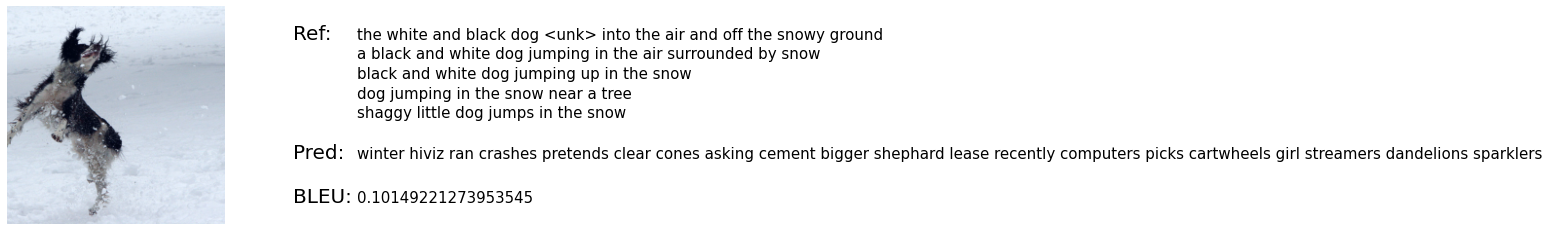

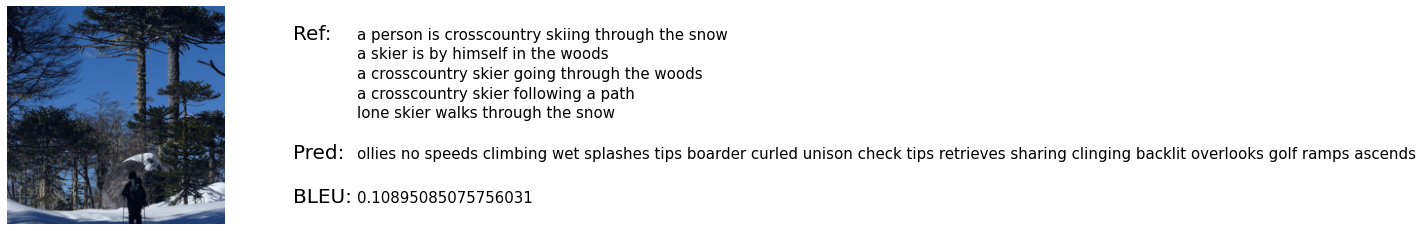

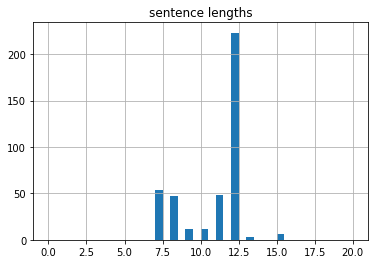

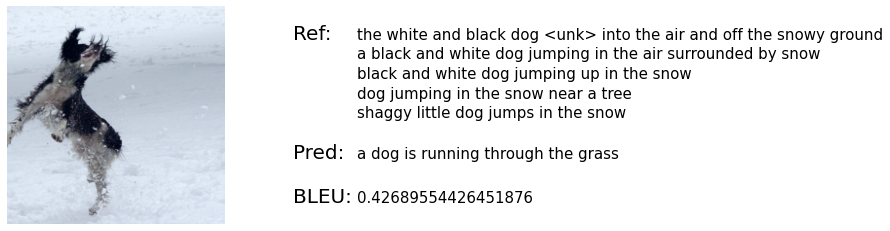

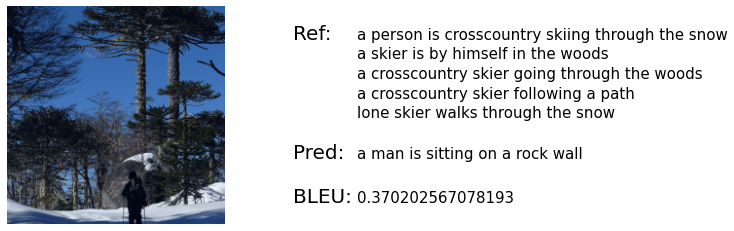

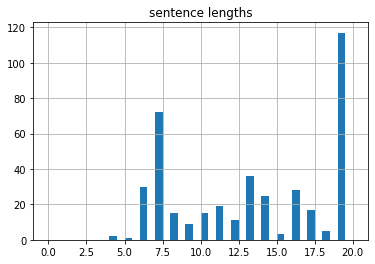

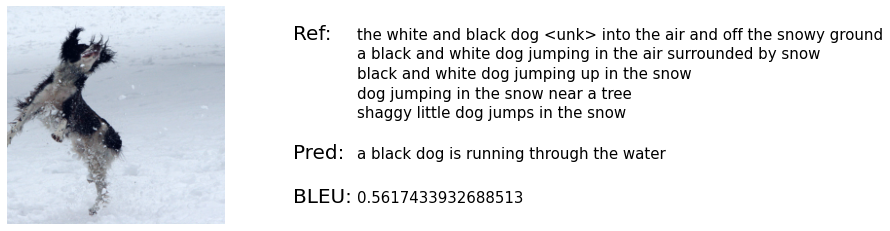

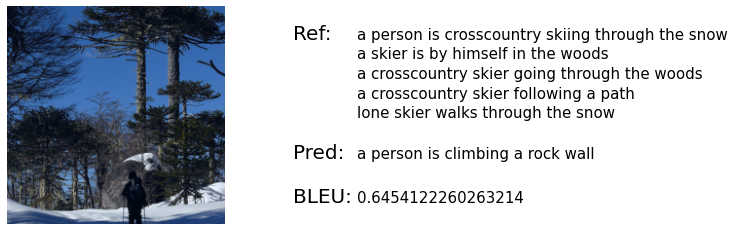

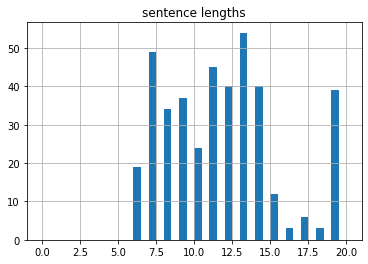

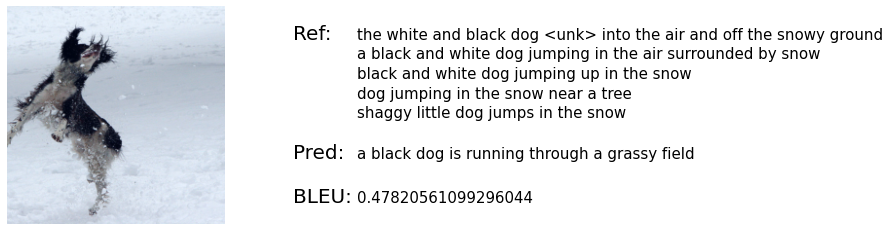

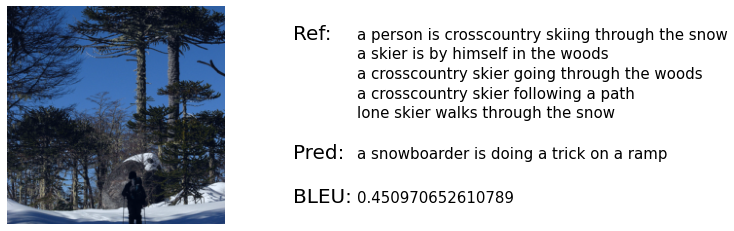

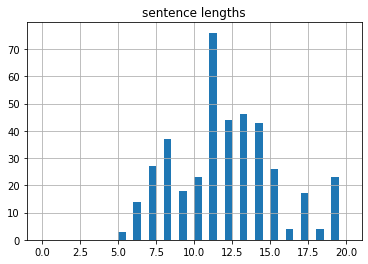

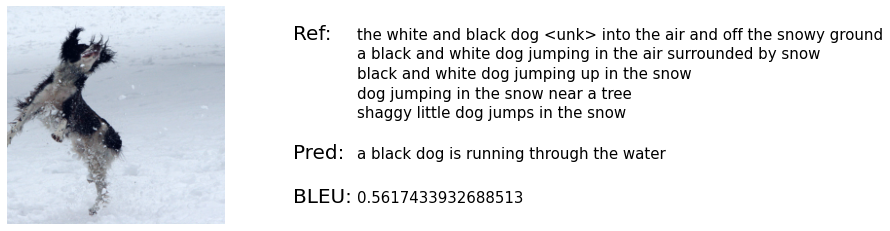

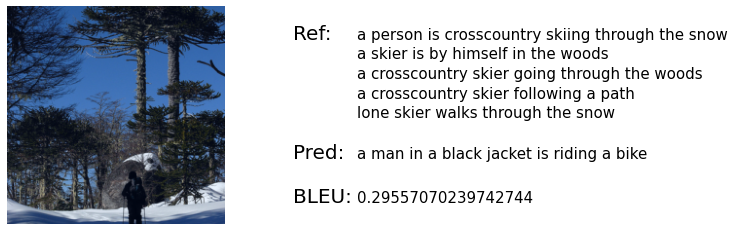

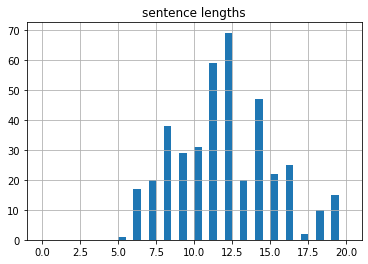

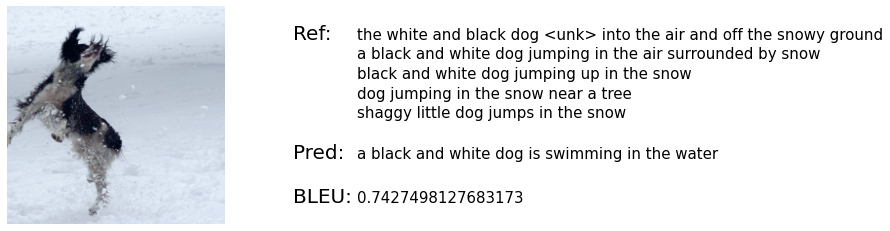

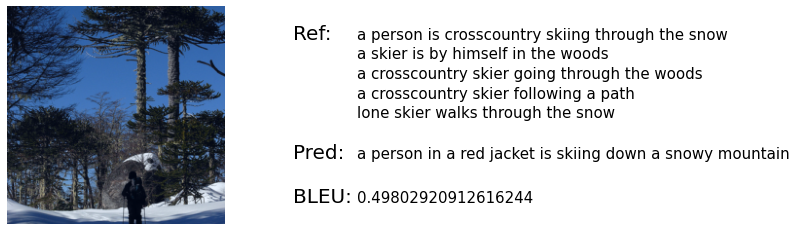

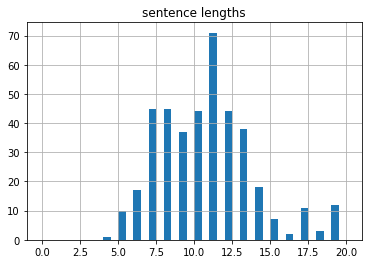

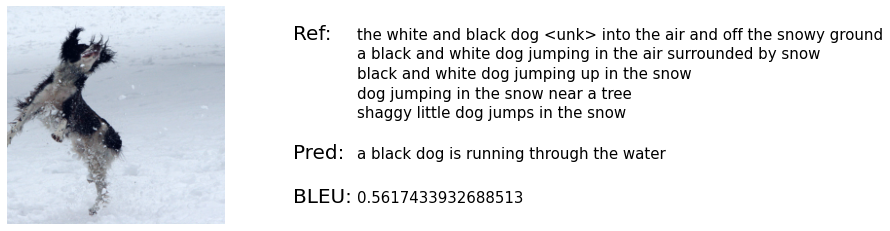

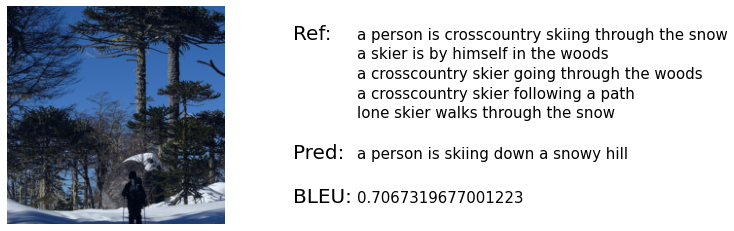

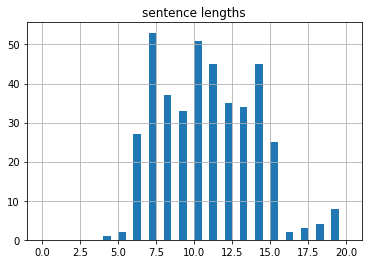

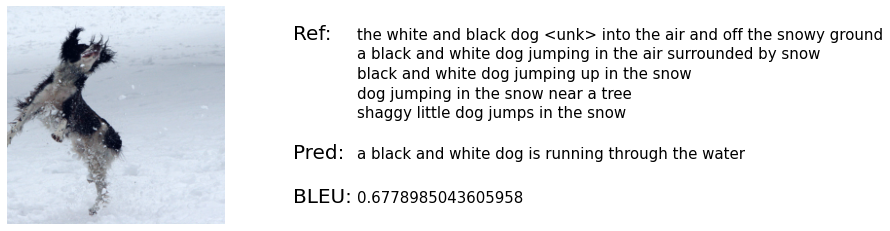

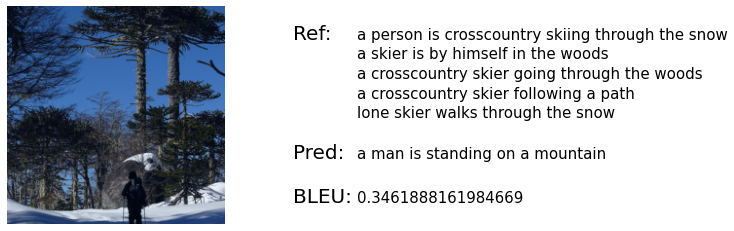

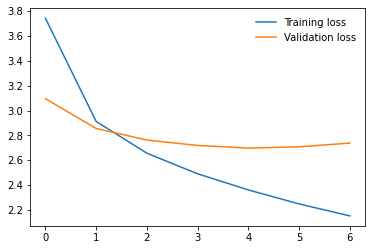

BLEU scores
[0.5119800526768897, 0.46680249461717577, 0.5125339532077199, 0.5172407634304295, 0.5470054299873855, 0.5444035877112244, 0.5383570324837578]
901.392482104
[10, 7, 8, 7, 11, 10, 7, 9, 12, 12, 15, 12, 15, 11, 11, 14, 10, 6, 9, 12, 8, 7, 11, 15, 11, 14, 9, 11, 11, 10, 12, 9, 10, 11, 7, 13, 12, 14, 11, 11, 7, 15, 10, 12, 12, 12, 7, 6, 8, 14, 10, 6, 8, 12, 10, 11, 13, 11, 6, 18, 14, 19, 13, 14, 7, 13, 11, 12, 7, 8, 7, 9, 7, 11, 14, 11, 6, 12, 7, 12, 13, 10, 7, 11, 7, 9, 6, 10, 8, 14, 7, 12, 11, 14, 14, 14, 6, 15, 8, 12, 6, 7, 13, 17, 18, 8, 7, 13, 11, 14, 9, 15, 14, 10, 4, 10, 15, 14, 10, 14, 7, 14, 7, 10, 15, 8, 18, 6, 10, 14, 7, 12, 10, 8, 7, 12, 7, 9, 12, 13, 14, 8, 10, 10, 11, 9, 13, 13, 13, 12, 13, 15, 6, 15, 10, 8, 8, 10, 6, 19, 12, 8, 9, 14, 13, 9, 9, 7, 7, 7, 9, 11, 19, 14, 7, 14, 12, 10, 14, 12, 10, 15, 10, 13, 14, 11, 6, 16, 8, 6, 15, 14, 15, 15, 14, 13, 7, 14, 9, 14, 11, 12, 9, 7, 10, 10, 11, 11, 10, 8, 8, 11, 7, 13, 7, 17, 9, 14, 8, 11, 15, 15, 14, 6, 14, 11, 10, 13

0.5383570324837578

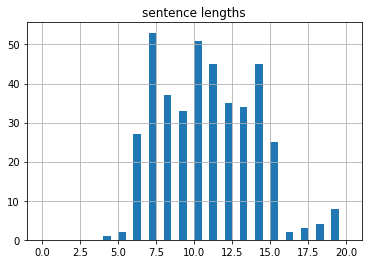

In [27]:
import time
import warnings
warnings.filterwarnings('ignore') # Deactivate warnings

num_epochs = 7
save_step = 1
t = time.process_time()
encoderRNN, decoderRNN = train_model(encoderRNN, decoderRNN, show=2, save='RNN')
elapsed_time = time.process_time() - t
print(elapsed_time)

path = f'{root}decoder-RNN-best.ckpt'
torch.save(encoderRNN.state_dict(), F'{path}')
path = f'{root}encoder-RNN-best.ckpt'
torch.save(decoderRNN.state_dict(), F'{path}')

Show 5 images

After Training
['the white and black dog <unk> into the air and off the snowy ground', 'a black and white dog jumping in the air surrounded by snow', 'black and white dog jumping up in the snow', 'dog jumping in the snow near a tree', 'shaggy little dog jumps in the snow']
a black and white dog is swimming in the water
0.7427498127683173
['a person is crosscountry skiing through the snow', 'a skier is by himself in the woods', 'a crosscountry skier going through the woods', 'a crosscountry skier following a path', 'lone skier walks through the snow']
a person in a red jacket is skiing down a snowy mountain
0.49802920912616244
['a brown and black dog is standing on its hind legs trying to catch something', 'a dog is jumping up on hind legs with its mouth open', 'a german shepherd playing with water in the grass', 'german shepherd standing up <unk> at droplets of water', 'a dog plays on the grass']
a brown dog is jumping up to catch a frisbee
0.7143645521018755
['the sun is <unk> through

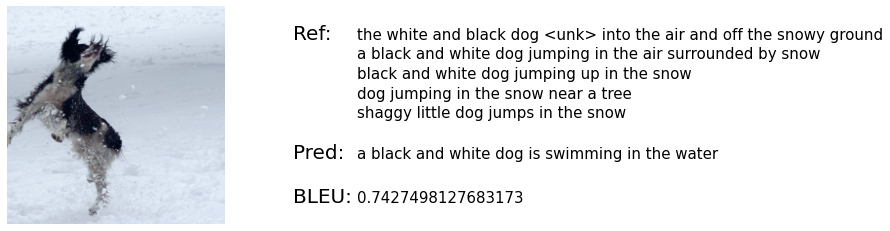

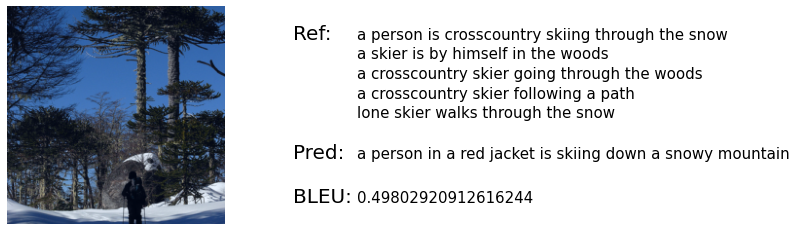

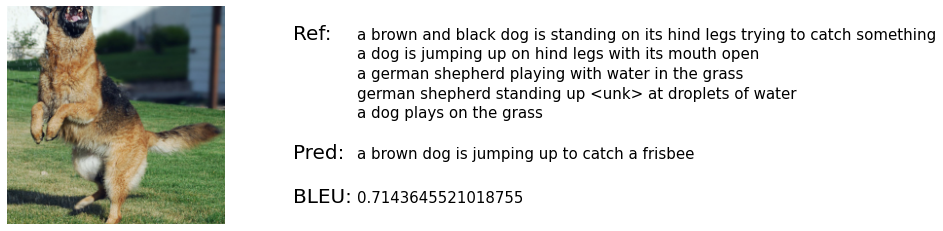

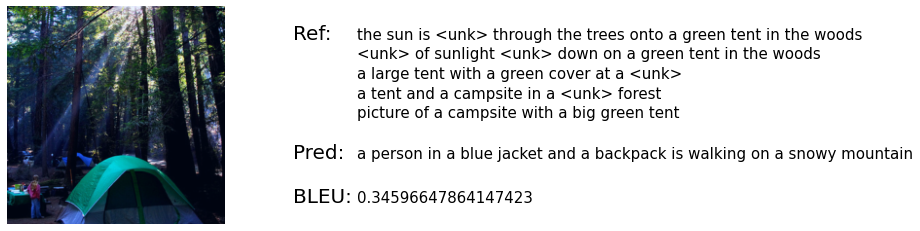

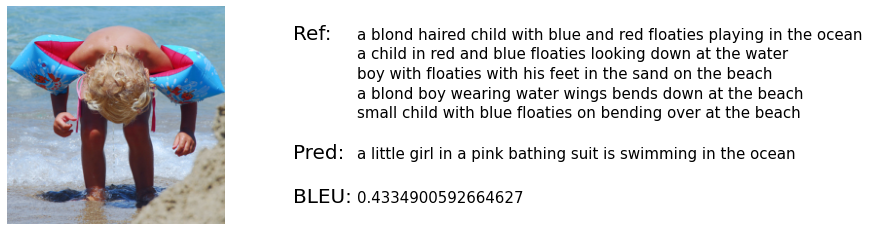

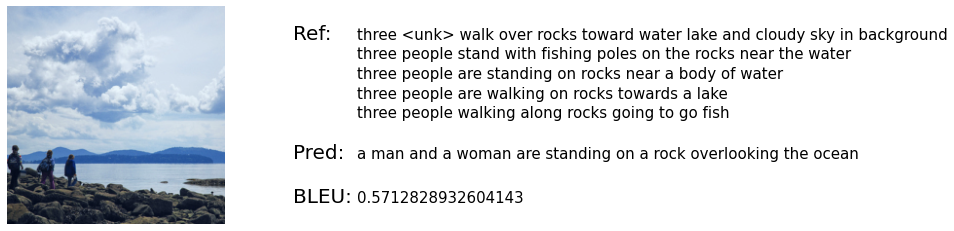

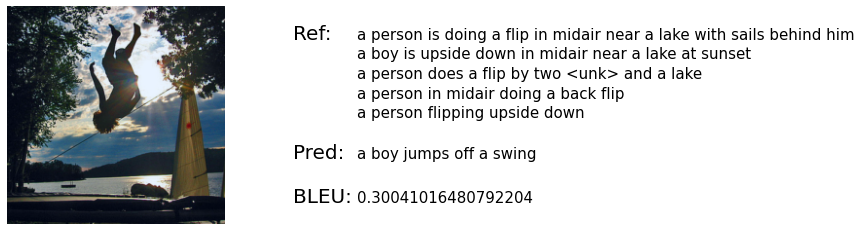

In [37]:
print('After Training')

# path = f'{root}encoder-RNN-best.ckpt'
# encoderRNN.load_state_dict(torch.load(F'{path}'))
# path = f'{root}decoder-RNN-best.ckpt'
# decoderRNN.load_state_dict(torch.load(F'{path}'))
# criterion, optimizer = loss_optimizer(encoderRNN, decoderRNN)

# Get data
test_images, test_captions, test_ids =  torch.tensor([], dtype=torch.float32), [], []
for i, (images_d, captions_d, _, ids_d) in enumerate(test_loader):
    test_images = torch.cat((test_images, images_d.cpu()))
    test_captions.extend(captions_d.tolist())
    test_ids.extend(ids_d)

# Get indexes
unique_ids = set(test_ids)
ids_image = []
for idx in unique_ids:
    indices = [i for i, x in enumerate(test_ids) if x == idx]
    ids_image.append(indices)

# Compute and show BLEU
for i in range(7):
    references = [test_captions[i] for i in ids_image[i]]
    score, _ = get_BLEU_image(encoderRNN, decoderRNN, test_images[ids_image[i][0]:ids_image[i][0]+1], references, show=True)

## LSTM for decoder

Initialize the models and set the learning parameters.

In [0]:
encoderLSTM, decoderLSTM = build_models(EncoderCNN, DecoderLSTM)
criterion, optimizer = loss_optimizer(encoderLSTM, decoderLSTM)

Initialize the models and set the learning parameters.

Before Training
['the white and black dog <unk> into the air and off the snowy ground', 'a black and white dog jumping in the air surrounded by snow', 'black and white dog jumping up in the snow', 'dog jumping in the snow near a tree', 'shaggy little dog jumps in the snow']
very border underneath tent village countryside innertube closeup photographed lay nips pig confetti marked uses photographed land forward forward floppy
0.10519355260393352
['a person is crosscountry skiing through the snow', 'a skier is by himself in the woods', 'a crosscountry skier going through the woods', 'a crosscountry skier following a path', 'lone skier walks through the snow']
bottle give snowcovered clearing cushion bottle craft landscape easter bluejeans narrow girls seats medium serve scenery trench screaming fallen thrown
0.14987220180032051
Epoch [0/7], Step [0/269]
Epoch [0/7], Step [25/269]
Epoch [0/7], Step [50/269]
Epoch [0/7], Step [75/269]
Epoch [0/7], Step [100/269]
Epoch [0/7], Step [125/269]

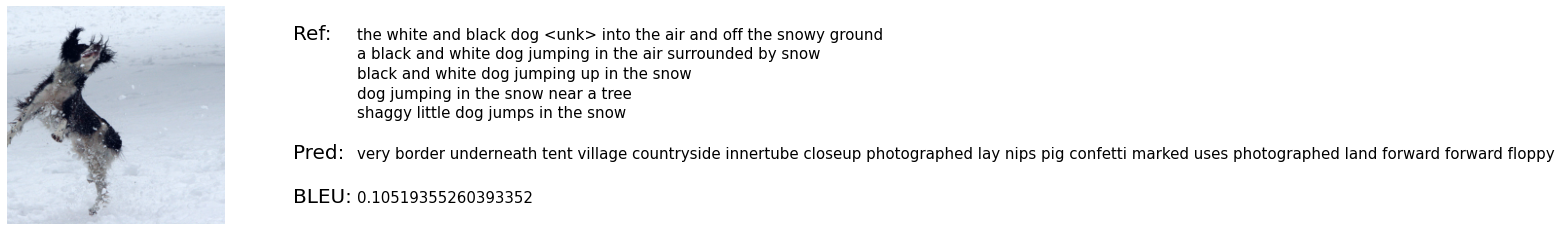

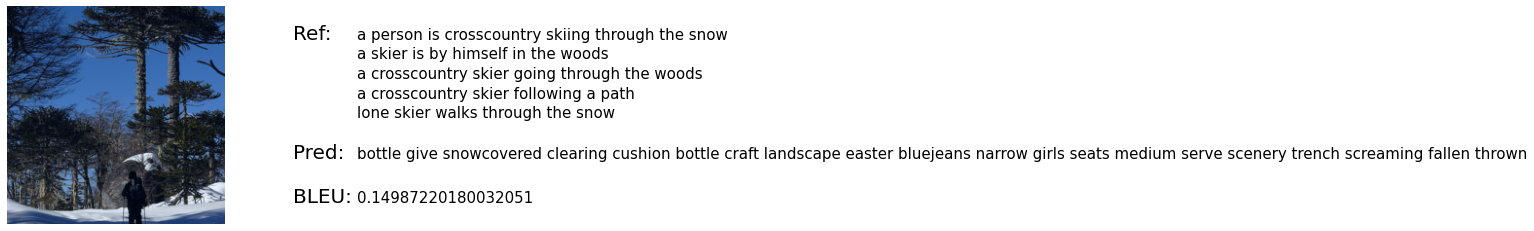

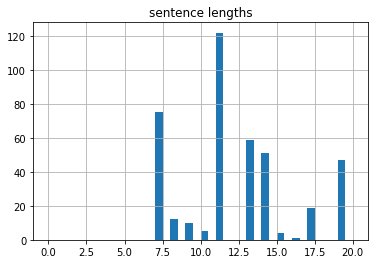

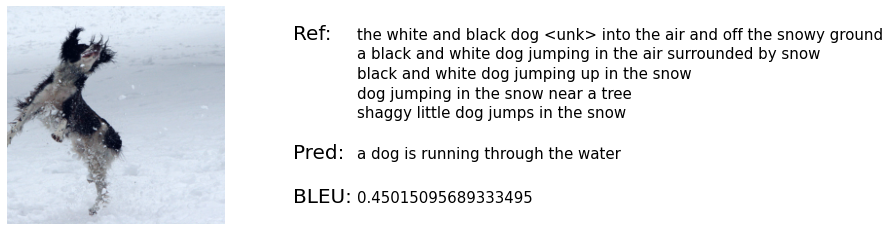

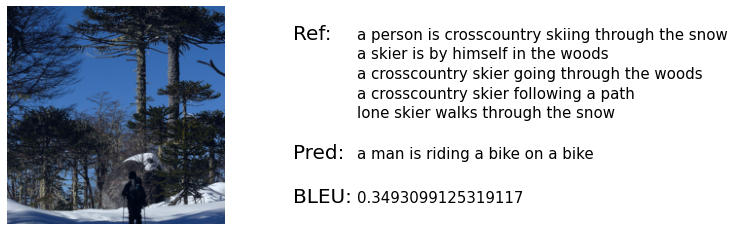

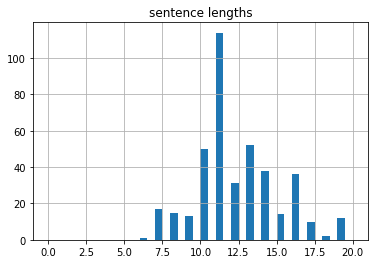

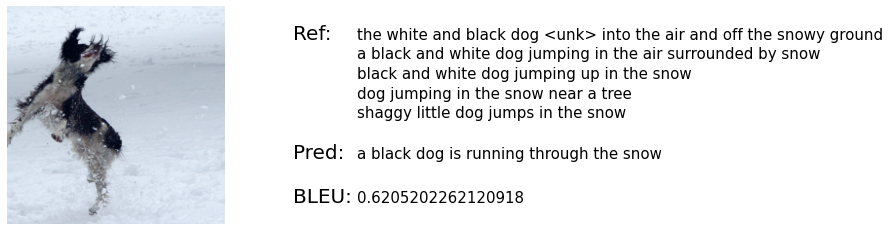

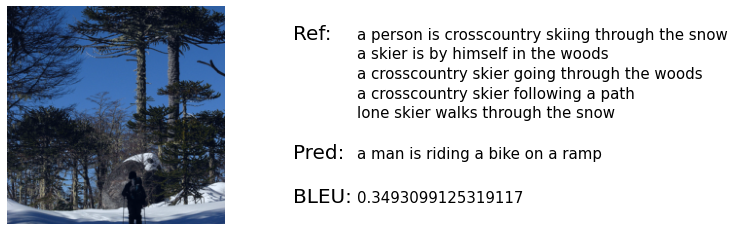

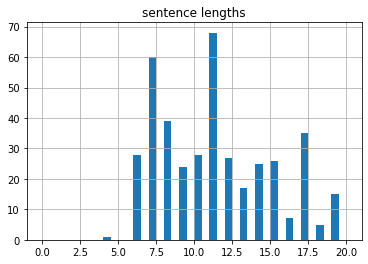

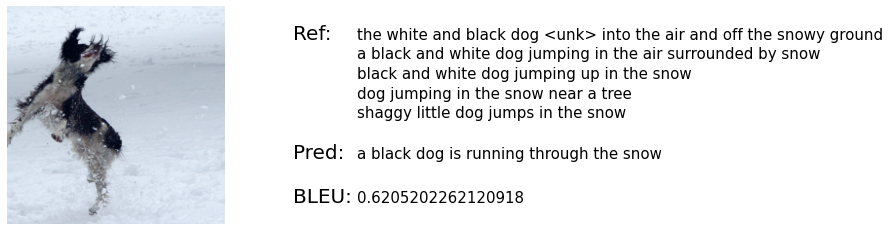

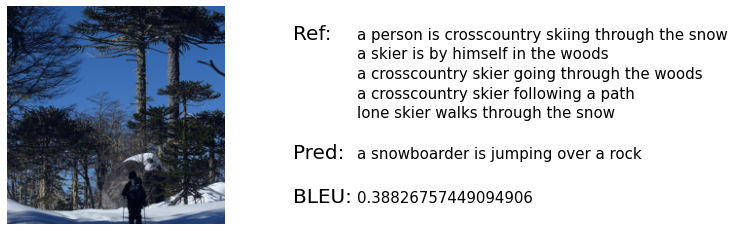

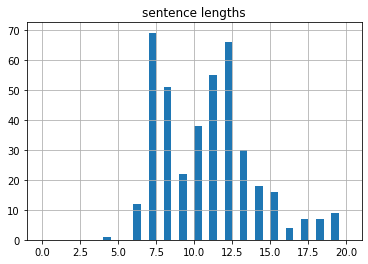

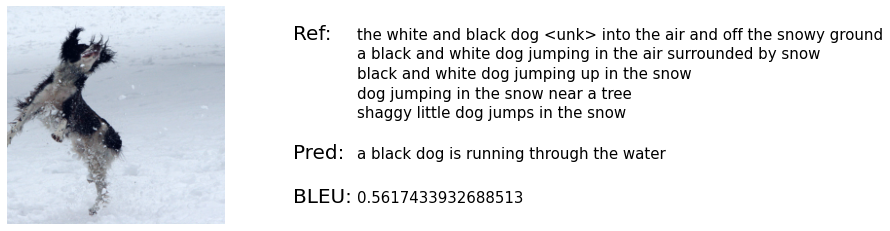

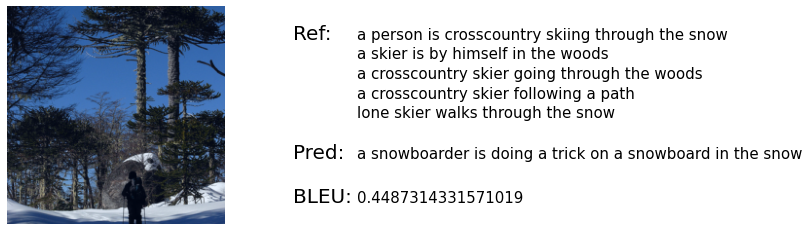

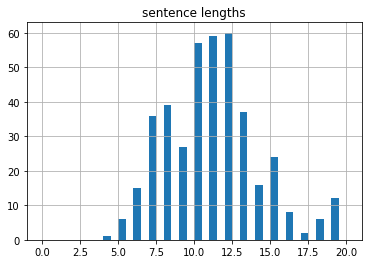

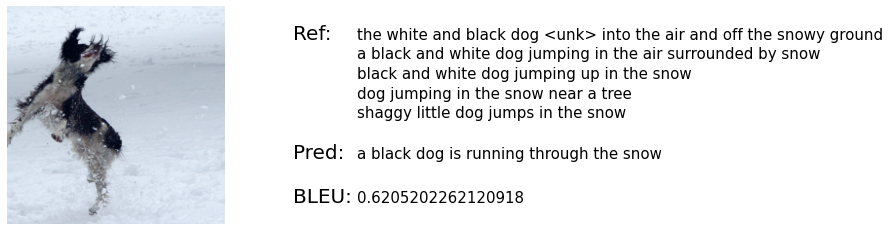

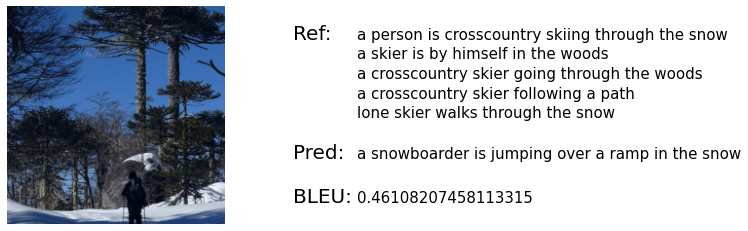

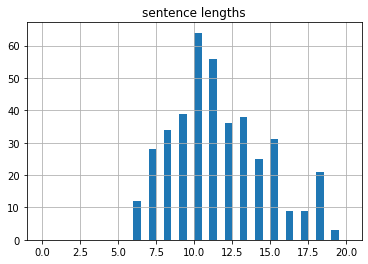

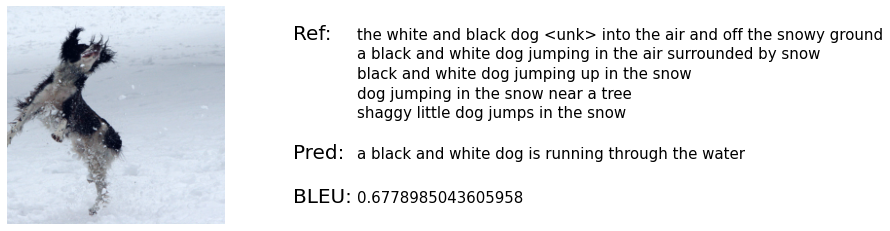

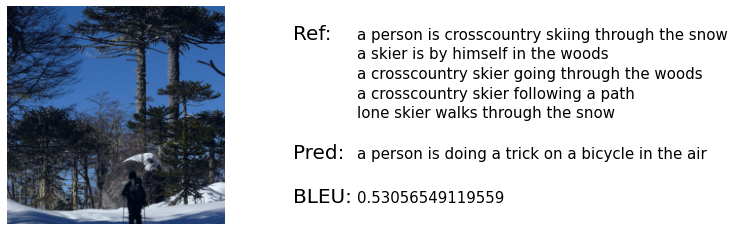

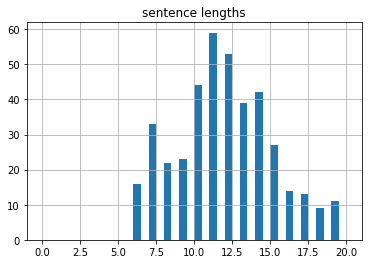

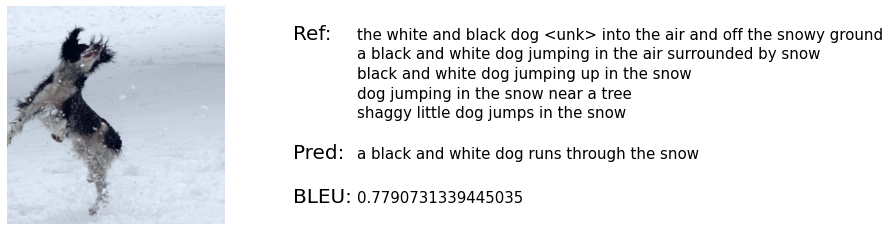

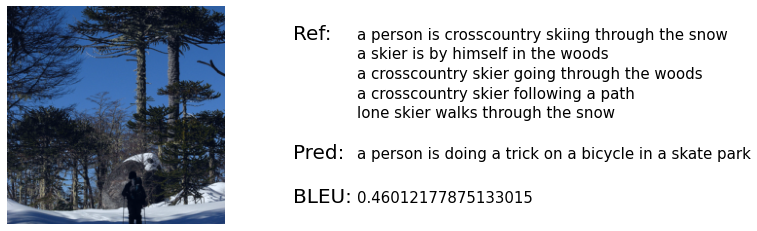

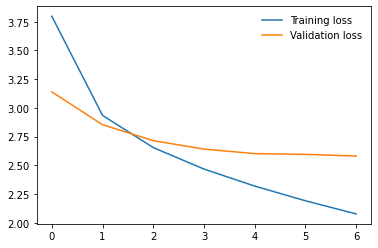

BLEU scores
[0.47719134005390546, 0.5205066968196823, 0.5334073469230528, 0.5597933295496292, 0.5752461761468649, 0.578723535817381, 0.5587901788435206]
880.897231905
[9, 13, 8, 9, 11, 12, 14, 6, 12, 17, 7, 11, 15, 11, 11, 12, 7, 7, 19, 16, 13, 11, 14, 18, 14, 12, 10, 16, 10, 10, 16, 11, 14, 8, 8, 12, 13, 14, 9, 10, 10, 12, 16, 6, 12, 14, 8, 7, 14, 14, 11, 7, 7, 11, 10, 11, 11, 18, 11, 12, 10, 15, 13, 15, 6, 12, 14, 11, 12, 8, 6, 8, 13, 14, 12, 12, 6, 13, 11, 10, 10, 11, 13, 8, 18, 9, 7, 14, 9, 12, 10, 12, 15, 8, 15, 12, 14, 10, 11, 14, 16, 12, 14, 7, 10, 15, 16, 13, 8, 9, 11, 13, 11, 12, 11, 10, 12, 18, 7, 18, 12, 14, 10, 10, 19, 17, 18, 6, 10, 14, 11, 12, 11, 12, 11, 18, 10, 12, 14, 19, 11, 9, 16, 6, 11, 9, 7, 7, 12, 15, 12, 17, 7, 11, 7, 10, 9, 12, 6, 11, 12, 7, 17, 11, 14, 14, 14, 11, 8, 15, 12, 11, 10, 13, 11, 14, 11, 14, 16, 19, 7, 13, 10, 11, 13, 15, 7, 10, 14, 13, 8, 19, 15, 19, 13, 14, 10, 11, 6, 13, 11, 12, 11, 13, 16, 6, 13, 19, 8, 15, 7, 10, 11, 14, 12, 6, 17, 16, 7, 11, 16

0.5587901788435206

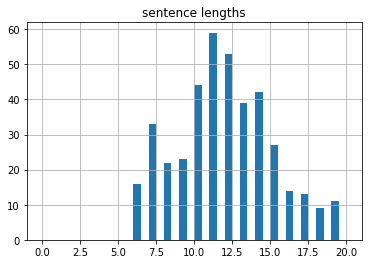

In [30]:
t = time.process_time()
encoderLSTM, decoderLSTM = train_model(encoderLSTM, decoderLSTM, show=2, save='LSTM')
elapsed_time = time.process_time() - t
print(elapsed_time)

path = f'{root}decoder-LSTM-best.ckpt'
torch.save(encoderLSTM.state_dict(), F'{path}')
path = f'{root}encoder-LSTM-best.ckpt'
torch.save(decoderLSTM.state_dict(), F'{path}')

Show more samples

['the white and black dog <unk> into the air and off the snowy ground', 'a black and white dog jumping in the air surrounded by snow', 'black and white dog jumping up in the snow', 'dog jumping in the snow near a tree', 'shaggy little dog jumps in the snow']
a black and white dog runs through the snow
0.7790731339445035
['a person is crosscountry skiing through the snow', 'a skier is by himself in the woods', 'a crosscountry skier going through the woods', 'a crosscountry skier following a path', 'lone skier walks through the snow']
a person is doing a trick on a bicycle in a skate park
0.46012177875133015
['a brown and black dog is standing on its hind legs trying to catch something', 'a dog is jumping up on hind legs with its mouth open', 'a german shepherd playing with water in the grass', 'german shepherd standing up <unk> at droplets of water', 'a dog plays on the grass']
a dog is running through a grassy field
0.41151020635116536
['the sun is <unk> through the trees onto a green 

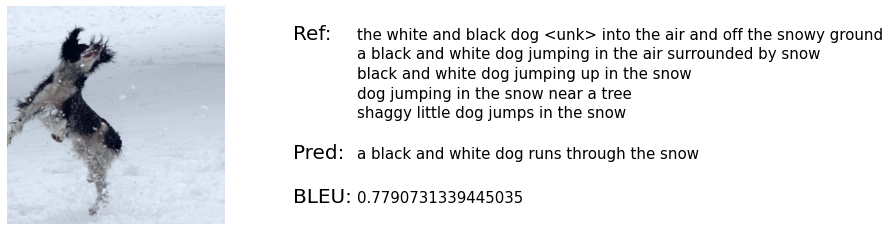

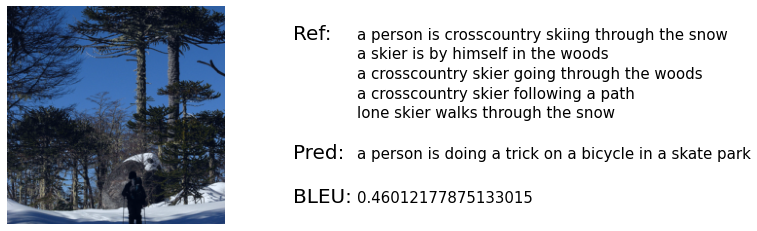

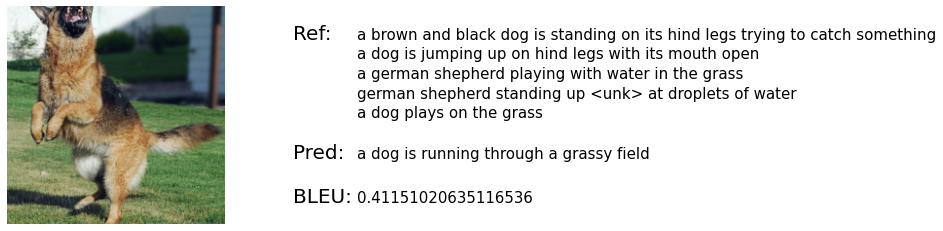

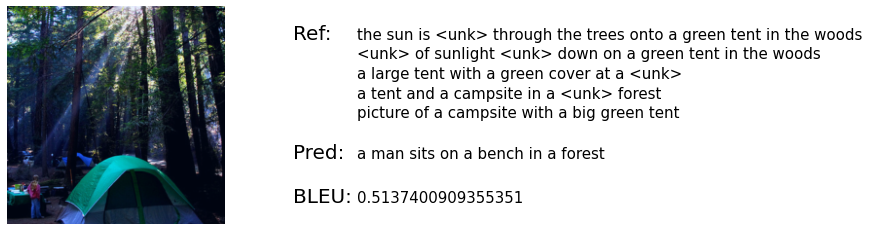

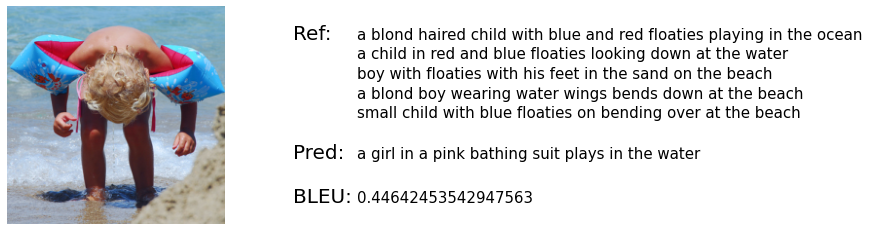

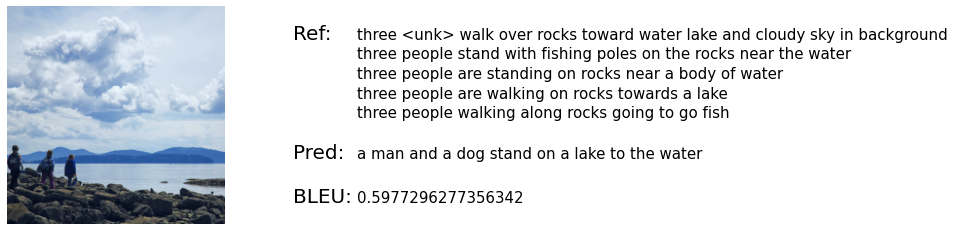

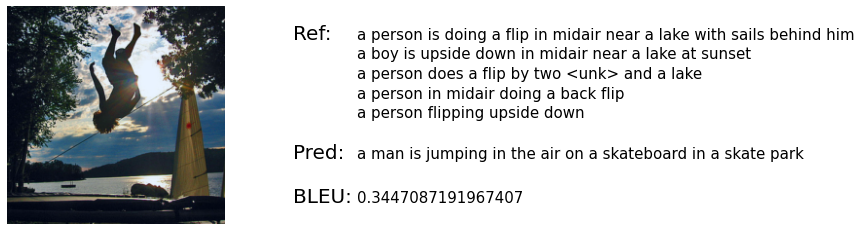

In [31]:
# Compute and show BLEU
for i in range(7):
    references = [test_captions[i] for i in ids_image[i]]
    score, _ = get_BLEU_image(encoderLSTM, decoderLSTM, test_images[ids_image[i][0]:ids_image[i][0]+1], references, show=True)

## Comparison

Get Data

In [0]:
# Initialize lists
images, captions, ids =  torch.tensor([], dtype=torch.float32),  [], []

with torch.no_grad():
  total_step = len(test_loader)
  for i, (images_d, captions_d, _, ids_d) in enumerate(test_loader):
    images = torch.cat((images, images_d.cpu()))
    captions.extend(captions_d.tolist())
    ids.extend(ids_d)

# Get indexes
unique_ids = set(ids)
ids_image = []
for idx in unique_ids:
  indices = [i for i, x in enumerate(ids) if x == idx]
  ids_image.append(indices)

Captions Quality

RNN        LSTM
count  405.000000  405.000000
mean    11.718519   11.730864
std      3.198047    3.157446
min      5.000000    6.000000
25%      9.000000   10.000000
50%     12.000000   12.000000
75%     14.000000   14.000000
max     19.000000   19.000000

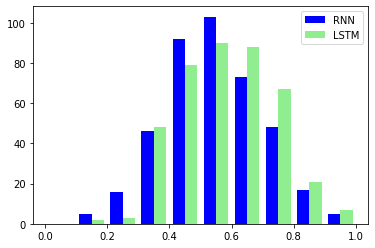

In [50]:
# Set evaluation mode
encoderRNN.eval()
decoderRNN.eval()
encoderLSTM.eval()
decoderLSTM.eval()

# Initialize lists
scoresRNN, scoresLSTM = [], []
candidatesRNN, candidatesLSTM = [], []

# Compute BLEU scores
for idx_group in ids_image:
  references = [captions[i] for i in idx_group]
  score, candidate = get_BLEU_image(encoderRNN, decoderRNN, images[idx_group[0]:idx_group[0]+1], references)   
  scoresRNN.append(score)
  candidatesRNN.append(len(candidate.split()))
  score, candidate = get_BLEU_image(encoderLSTM, decoderLSTM, images[idx_group[0]:idx_group[0]+1], references)   
  scoresLSTM.append(score)
  candidatesLSTM.append(len(candidate.split()))

plt.figure()
plt.hist([scoresRNN, scoresLSTM], range=[0,1], label=['RNN', 'LSTM'], color=['blue', 'lightgreen'])
plt.legend()

candidates_data = {"RNN" : candidatesRNN, "LSTM": candidatesLSTM}
candidates_df = pd.DataFrame(candidates_data)
candidates_df.describe()

Length Comparison

In [0]:
def get_average_bleu_by_length(encoder, decoder, lim1, lim2, lim3):
    # Initialize lists
    scoresShort1, scoresLong1 = [], []
    scoresShort2, scoresLong2 = [], []
    scoresShort3, scoresLong3 = [], []

    # Compute BLEU scores
    for idx_group in ids_image:
        references = [captions[i] for i in idx_group]
        score, candidate = get_BLEU_image(encoder, decoder, images[idx_group[0]:idx_group[0]+1], references)   
        score += 0.02
        w_length = len(candidate.split())
        if w_length < lim1:
            scoresShort1.append(score)
        else:
            scoresLong1.append(score)
        if w_length < lim2:
            scoresShort2.append(score)
        else:
            scoresLong2.append(score)
        if w_length < lim3:
            scoresShort3.append(score)
        else:
            scoresLong3.append(score)
    
    if len(scoresShort1) > 0:
      print(lim1)
      print(sum(scoresShort1) / len(scoresShort1))
      print(sum(scoresLong1) / len(scoresLong1))
    if len(scoresShort2) > 0:
      print(lim2)
      print(sum(scoresShort2) / len(scoresShort2))
      print(sum(scoresLong2) / len(scoresLong2))
    if len(scoresShort3) > 0:
      print(lim3)
      print(sum(scoresShort3) / len(scoresShort3))
      print(sum(scoresLong3) / len(scoresLong3))

In [63]:
print('RNN')
get_average_bleu_by_length(encoderRNN, decoderRNN, 5, 7, 9)
get_average_bleu_by_length(encoderRNN, decoderRNN, 11, 13, 15)
get_average_bleu_by_length(encoderRNN, decoderRNN, 17, 19, 19)

RNN
7
0.4641821112422566
0.55085767737088
9
0.5672137191709477
0.5423372537626114
11
0.5762027364836044
0.5322439664800038
13
0.5728752995018311
0.4985682274922537
15
0.562660654179378
0.47698003529077043
17
0.5534024925334439
0.45744655434257103
19
0.55241390200827
0.406385157444395
19
0.55241390200827
0.406385157444395


In [67]:
print('LSTM')
get_average_bleu_by_length(encoderLSTM, decoderLSTM, 5, 7, 9)
get_average_bleu_by_length(encoderLSTM, decoderLSTM, 11, 13, 15)
get_average_bleu_by_length(encoderLSTM, decoderLSTM, 17, 19, 19)

LSTM
7
0.5799592822441606
0.5787420923283265
9
0.6085604311164957
0.5724617719232168
11
0.6003753157478035
0.5676338159491714
13
0.592135378709481
0.5572656629306798
15
0.5883234425225519
0.5361481480629852
17
0.5841775143696278
0.5180602147310318
19
0.5812693442655196
0.4899909810009843
19
0.5812693442655196
0.4899909810009843
